# An introduction to I-24 MOTION trajectory data

## Useful links
- I24 MOTION website: https://i24motion.org/
- Request for data access: https://i24motion.org/data
- Data documentation: https://github.com/I24-MOTION/I24M_documentation
- Improvement tracker: https://github.com/I24-MOTION/I24M_improvement_tracker

## This tutorial will cover:
- Load JSON file using iterative JSON parser
- Trajectory data schema
- Compute derivative quantities (e.g., speed)
- Visualize a trajectory
- Plot a time-space diagram

## Import packages

In [8]:
import ijson
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime
from decimal import Decimal

### Read a JSON file using an iterative JSON parser

In [9]:
input_filename = "data_00.json"
file_path = os.path.join("data", input_filename)

# Select one trajectory from westbound
with open(file_path, 'r') as input_file:
    parser = ijson.items(input_file, 'item')
    for record in parser:
        if record["direction"] == -1 and (record["last_timestamp"]-record["first_timestamp"]>10):
            print("Found a trajectory example")
            break

Found a trajectory example


In [10]:
for key, val in record.items():
    print(f"{key}: {val}")

_id: {'$oid': '648f27a52728071a2add5eda'}
timestamp: [Decimal('1668513600.0108645'), Decimal('1668513600.0508645'), Decimal('1668513600.0908644'), Decimal('1668513600.1308644'), Decimal('1668513600.1708646'), Decimal('1668513600.2108645'), Decimal('1668513600.2508645'), Decimal('1668513600.2908645'), Decimal('1668513600.3308644'), Decimal('1668513600.3708644'), Decimal('1668513600.4108646'), Decimal('1668513600.4508646'), Decimal('1668513600.4908645'), Decimal('1668513600.5308645'), Decimal('1668513600.5708644'), Decimal('1668513600.6108644'), Decimal('1668513600.6508646'), Decimal('1668513600.6908646'), Decimal('1668513600.7308645'), Decimal('1668513600.7708645'), Decimal('1668513600.8108644'), Decimal('1668513600.8508644'), Decimal('1668513600.8908644'), Decimal('1668513600.9308646'), Decimal('1668513600.9708645'), Decimal('1668513601.0108645'), Decimal('1668513601.0508645'), Decimal('1668513601.0908644'), Decimal('1668513601.1308644'), Decimal('1668513601.1708646'), Decimal('1668513

### Convert from Decimal to float

In [11]:
class DecimalToFloatConverter:
    @staticmethod
    def convert_dict(dec_dict):
        if not isinstance(dec_dict, dict):
            raise ValueError("Input must be a dictionary")

        float_dict = {}
        for key, value in dec_dict.items():
            if isinstance(value, list):
                try:
                    float_dict[key] = np.array(value, dtype="float")
                except:
                    pass
            elif isinstance(value, Decimal):
                float_dict[key] = float(value)
            else:
                float_dict[key] = value
        
        return float_dict
    
converter = DecimalToFloatConverter()
record = converter.convert_dict(record)
print(record["x_position"][:10])

[330892.43079559 330889.6452784  330886.86038359 330884.07611155
 330881.29246303 330878.50943909 330875.72704094 330872.94526975
 330870.16412647 330867.38361148]


### Compute the derivative quantities

In [12]:
speed = np.diff(record["x_position"])/np.diff(record["timestamp"])*record["direction"]
speed = np.append(speed[0], speed) 
speed[:10]*0.681818

array([47.48043934, 47.48043934, 47.46983051, 47.4592151 , 47.44830398,
       47.43794063, 47.42727392, 47.41658692, 47.40588398, 47.39517438])

In [13]:
accel = np.diff(record["x_position"], n=2)/(np.diff(record["timestamp"][:-1])**2)*record["direction"]
accel[:10]

array([-0.38899083, -0.38923217, -0.38970536, -0.39035493, -0.3911133 ,
       -0.39185716, -0.39244175, -0.39268575, -0.39247489, -0.39174644])

### Visualize a trajectory

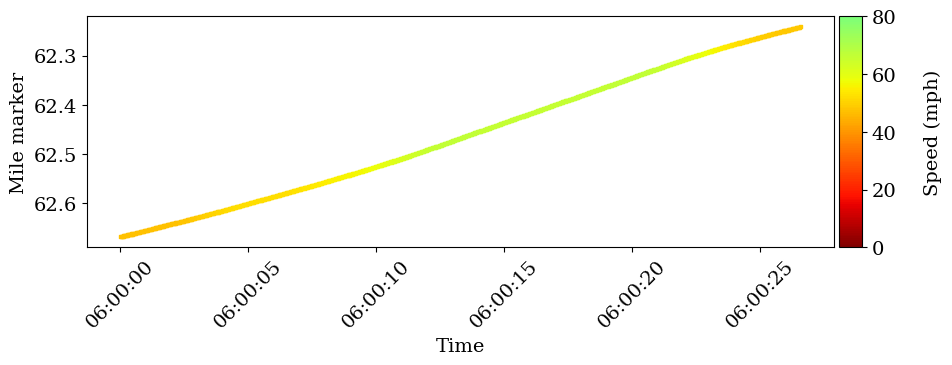

In [14]:
# Set up the plot
plt.rc('font', family='serif', size=14)
fig, ax = plt.subplots(figsize=(10,3))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)

# Define the color range
jet = plt.cm.jet
colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

im = ax.scatter(record["timestamp"], record["x_position"]/5280, c= speed*0.681818, cmap=green_to_red,vmin=0,vmax=80,marker = 's',s=5)
plt.colorbar(im, cax=cax).set_label('Speed (mph)', rotation=90, labelpad=20)
ax.set_xlabel("Time")
ax.set_ylabel("Mile marker")

# Update x-axis time to readable format
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
x_datetime = [datetime.datetime.fromtimestamp(ts) for ts in ticks_loc]
labels = [d.strftime('%H:%M:%S') for d in x_datetime]
ax.set_xticklabels(labels, rotation=45)

# Invert vertically
ax.invert_yaxis()


### Plot a time-space diagram (6:00-6:10 AM, Westbound)

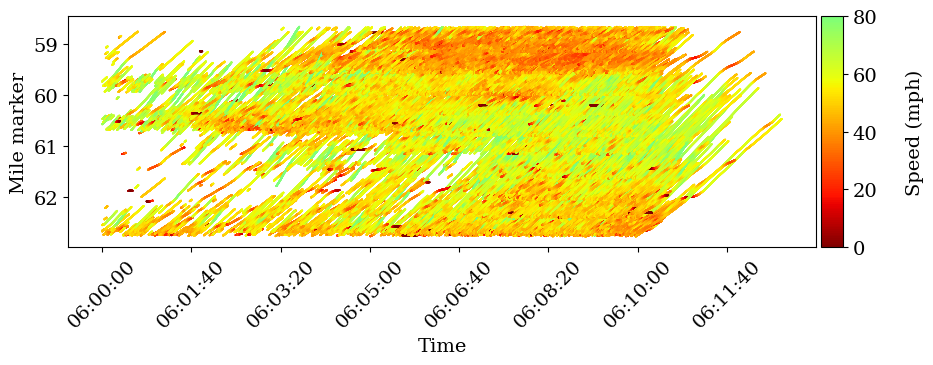

In [14]:
# Set up the plot
plt.rc('font', family='serif', size=14)
fig, ax = plt.subplots(figsize=(10,3))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)

# Define the color range
jet = plt.cm.jet
colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

# Select one trajectory from westbound
with open(file_path, 'r') as input_file:
    parser = ijson.items(input_file, 'item')
    for record in parser:  
        if record["direction"] == -1:
            record = converter.convert_dict(record)
            speed = np.diff(record["x_position"])/np.diff(record["timestamp"])
            speed = np.append(speed[0], speed)   
            im = ax.scatter(record["timestamp"], record["x_position"]/5280, c= -speed*0.681818, cmap=green_to_red,vmin=0,vmax=80,s=0.1)
plt.colorbar(im, cax=cax).set_label('Speed (mph)', rotation=90, labelpad=20)
ax.set_xlabel("Time")
ax.set_ylabel("Mile marker")

# Update x-axis time to readable format
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
x_datetime = [datetime.datetime.fromtimestamp(ts) for ts in ticks_loc]
labels = [d.strftime('%H:%M:%S') for d in x_datetime]
ax.set_xticklabels(labels, rotation=45)

# Invert vertically
ax.invert_yaxis()

### Plot a time-space diagram (8:00-8:10 AM, Westbound)

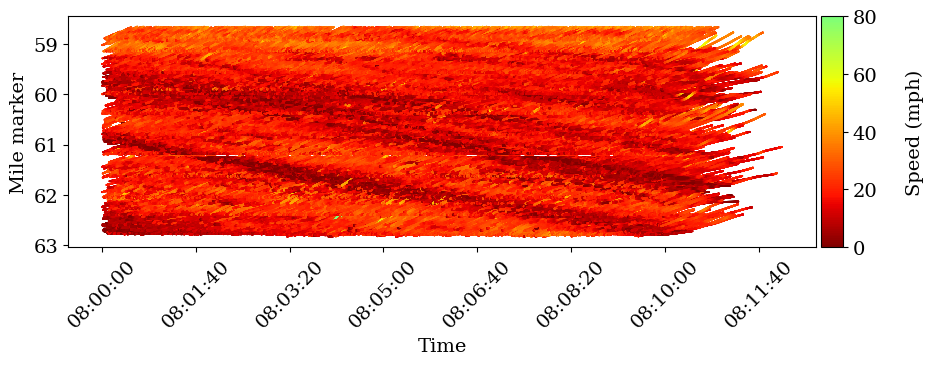

In [15]:
input_filename = "data_12.json"
file_path = os.path.join("data", input_filename)

# Set up the plot
plt.rc('font', family='serif', size=14)
fig, ax = plt.subplots(figsize=(10,3))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)

# Define the color range
jet = plt.cm.jet
colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

# Select one trajectory from westbound
with open(file_path, 'r') as input_file:
    parser = ijson.items(input_file, 'item')
    for record in parser:  
        if record["direction"] == -1:
            record = converter.convert_dict(record)
            speed = np.diff(record["x_position"])/np.diff(record["timestamp"])
            speed = np.append(speed[0], speed)   
            im = ax.scatter(record["timestamp"], record["x_position"]/5280, c= -speed*0.681818, cmap=green_to_red,vmin=0,vmax=80,s=0.1)
plt.colorbar(im, cax=cax).set_label('Speed (mph)', rotation=90, labelpad=20)
ax.set_xlabel("Time")
ax.set_ylabel("Mile marker")

# Update x-axis time to readable format
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
x_datetime = [datetime.datetime.fromtimestamp(ts) for ts in ticks_loc]
labels = [d.strftime('%H:%M:%S') for d in x_datetime]
ax.set_xticklabels(labels, rotation=45)

# Invert vertically
ax.invert_yaxis()